In [1]:
pwd

'/afs/crc.nd.edu/user/m/msaebi/Public/chemistry/yield-rxn'

In [1]:
import argparse
import logging
import os
import torch
from torch.utils.data import DataLoader, random_split
import json
import rdkit.Chem as Chem
#from rxntorch.models.reactivity_network import ReactivityNet as RxnNet, ReactivityTrainer as RxnTrainer
#from rxntorch.utils import collate_fn
import rdkit
from rxntorch.containers.reaction import Rxn
from rxntorch.containers.molecule import Mol
from rxntorch.containers.dataset import RxnGraphDataset as RxnGD
from rxntorch.utils import collate_fn
from rxntorch.models.yield_network import YieldNet as RxnNet, YieldTrainer as RxnTrainer
import warnings
warnings.filterwarnings("ignore")
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from collections import defaultdict

In [2]:
from torch import randperm
from torch._utils import _accumulate
from torch.utils.data import Dataset,Subset
def utils_random_split(dataset, lengths,generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.
    """
    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):  # type: ignore
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]



In [3]:
parser = argparse.ArgumentParser()

parser.add_argument("-p", "--dataset_path", type=str, default='./data/', help="train dataset")
#parser.add_argument("-mp","--mol_path", type=str, default='doyle_reaction_mols', help="path to mol files")

parser.add_argument("-c", "--train_dataset", required=True, type=str, help="train dataset")
parser.add_argument("-t", "--test_dataset", type=str, default=None, help="test set")
parser.add_argument("-op", "--output_path", type=str, default='./output/', help="saved model path")
parser.add_argument("-o", "--output_name", required=True, type=str, help="e.g. rxntorch.model")
parser.add_argument("-ds", "--train_split", type=float, default=0.7, help="Ratio of samples to reserve for test data")
parser.add_argument("-vs", "--valid_split", type=float, default=0.333, help="Ratio of samples to reserve for valid data")
parser.add_argument("-dr", "--dropout_rate", type=float, default=0.333, help="Ratio of samples to reserve for valid data")

parser.add_argument("-b", "--batch_size", type=int, default=40, help="number of batch_size")
parser.add_argument("-tb", "--test_batch_size", type=int, default=None, help="batch size for evaluation")
parser.add_argument("-e", "--epochs", type=int, default=10, help="number of epochs")
parser.add_argument("-hs", "--hidden", type=int, default=300, help="hidden size of model layers")
parser.add_argument("-l", "--layers", type=int, default=3, help="number of layers")

parser.add_argument("--lr", type=float, default=1e-2, help="learning rate of the optimizer")
parser.add_argument("-lrd", "--lr_decay", type=float, default=0.9,
                    help="Decay factor for reducing the learning rate")
parser.add_argument("-lrs", "--lr_steps", type=int, default=10000,
                    help="Number of steps between learning rate decay")
parser.add_argument("-awd","--adam_weight_decay", type=float, default=0.0, help="weight_decay of adam")
parser.add_argument("--adam_beta1", type=float, default=0.9, help="adam first beta value")
parser.add_argument("--adam_beta2", type=float, default=0.999, help="adam second beta value")
parser.add_argument("-gc", "--grad_clip", type=float, default=None, help="value for gradient clipping")
parser.add_argument("-pw", "--pos_weight", type=float, default=None, help="Weights positive samples for imbalance")

parser.add_argument("-w", "--num_workers", type=int, default=4, help="dataloader worker size")
parser.add_argument("--with_cuda", type=bool, default=True, help="training with CUDA: true, or false")
parser.add_argument("--cuda_devices", type=int, nargs='*', default=None, help="CUDA device ids")

parser.add_argument("--log_freq", type=int, default=50, help="printing loss every n iter: setting n")
parser.add_argument("--seed", type=int, default=12, help="random seed")
parser.add_argument("-ud","--use_domain", type=str, required='True', help="use domain features or not")

_StoreAction(option_strings=['-ud', '--use_domain'], dest='use_domain', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, help='use domain features or not', metavar=None)

In [4]:
import torch.nn.functional as F
source = torch.rand((20,10,10,10))
d2=78
l1, l2, l3, l4 =source.shape
# now we expand to size (7, 11) by appending a row of 0s at pos 0 and pos 6, 
# and a column of 0s at pos 10
result = F.pad(input=source, pad=(0, 0,  0, d2-l2,  0,d2-l3), mode='constant', value=0)
print(source.shape, result.shape)


result = F.pad(input=source, pad=(0, 1, 0, 1), mode='constant', value=0)
print(source.shape, result.shape)

result = F.pad(input=source, pad=(0, 2, 0, 0), mode='constant', value=0)
print(source.shape, result.shape)

result = F.pad(input=source, pad=(1, 1, 0, 0), mode='constant', value=0)
print(source.shape, result.shape)


result = F.pad(input=source, pad=(2, 4, 0, 0), mode='constant', value=0)
print(source.shape, result.shape)

torch.Size([20, 10, 10, 10]) torch.Size([20, 78, 78, 10])
torch.Size([20, 10, 10, 10]) torch.Size([20, 10, 11, 11])
torch.Size([20, 10, 10, 10]) torch.Size([20, 10, 10, 12])
torch.Size([20, 10, 10, 10]) torch.Size([20, 10, 10, 12])
torch.Size([20, 10, 10, 10]) torch.Size([20, 10, 10, 16])


In [5]:
#args = parser.parse_args()
data_type='su'
#args = parser.parse_args(args=['-p','data/','-c', data_type+'_reactions_data.json', '-o', 'model.01','-ud', 'False'])
args = parser.parse_args(args=['-p','data/','-c', data_type+'/'+data_type+'_reactions_data.json', '-o', 'model.01','-ud', 'True'])
random_seed=args.seed
#args.dataset_path="/afs/crc.nd.edu/user/m/msaebi/Public/Chem/yield-rxn/data/"
#args.train_dataset="doyle_reactions_data.json"
args.output_name="reactivity.model"

if not os.path.exists(args.output_path):
    os.mkdir(args.output_path)
outputfile = os.path.join(args.output_path, args.output_name)
logfile = '.'.join((args.output_name, "log"))
logpath = os.path.join(args.output_path, logfile)
logging.basicConfig(level=logging.INFO, style='{', format="{asctime:s}: {message:s}",
                    datefmt="%m/%d/%y %H:%M:%S", handlers=(
                    logging.FileHandler(logpath), logging.StreamHandler()))

logging.info("{:-^80}".format("Dataset"))
dataset = RxnGD(args.train_dataset, args.dataset_path, args.use_domain)
sample = dataset[1]

04/22/21 16:37:24: ------------------------------------Dataset-------------------------------------
04/22/21 16:37:24: Loading Dataset su/su_reactions_data.json in data/
04/22/21 16:37:53: Dataset contains 4620 total samples
04/22/21 16:37:53: 4620 number of appends 
04/22/21 16:37:53: 85 max number of atoms 


In [6]:
print('atom_feats ', sample['atom_feats'].shape)
print('bond_feats ', sample['bond_feats'].shape) 
print('charge_feats ', sample['charge_feats'].shape)
print('nmr_feats ', sample['nmr_feats'].shape)
print('atom_graph ', sample['atom_graph'].shape)
print('bond_graph ', sample['bond_graph'].shape)
print('domain_feats ', sample['domain_feats'].shape)
print("binary_feats ", sample["binary_feats"].shape)

atom_feats  torch.Size([49, 27])
bond_feats  torch.Size([54, 5])
charge_feats  torch.Size([85, 85])
nmr_feats  torch.Size([85, 85])
atom_graph  torch.Size([49, 15])
bond_graph  torch.Size([49, 15])
domain_feats  torch.Size([1, 361])
binary_feats  torch.Size([15, 15, 15])


import math
data_type='su/su'
mol_path= 'data/'+data_type+ '_reaction_mols'
max_nmr=0
max_ch=0
min_nmr=math.inf
min_ch=math.inf
import glob
import re

def get_atom_mapping_doyle(mol_dir):
    
    smiles_mapping=defaultdict(dict) 
    if 'doyle' in mol_dir:
        mol_dir=mol_dir.replace('.sdf','.mol')
        print(mol_dir)
    for mol_fn in glob.glob(mol_dir):
        atoms , labels, atom_mapping =[], [], []
        
        m = Chem.MolFromMolFile(mol_fn)
        smiles=Chem.MolToSmiles(m)
        mol_lines=open(mol_fn,'r').readlines()
        counter=defaultdict(int)
        for i,line in enumerate(mol_lines[4:]):
            l=re.sub(' +', ' ', line.strip('\n')).split(' ')
            if len(l)>10:
                if len(l)==17:
                    atom=l[4]
                    if atom !='' and '*' not in atom and 'H' not in atom:     
                        atoms.append(atom)
                        counter[atom]+=1
                        labels.append(atom+str(counter[atom]))
                #if "atom_labels" in line: # for Doyle
                    #labels=[i.strip('*') for i in mol_lines[i+1+4].strip('\n').split(' ') if ((i!='') and ('H' not in i))]
                    
        if len(atoms)==len(labels):
            for i in range(len(atoms)):
                atom_mapping.append((atoms[i],labels[i]))            
        else:
            print('Atoms and lables don\'t match')
            print(len(atoms),len(labels))
            atom_mapping=[]

        if smiles not in smiles_mapping:
            smiles_mapping[mol_fn.split('/')[-1].split('.')[0]]=atom_mapping
        else:
            print("key exsists")
    return smiles_mapping

if True:    
    def get_atom_domain_features(mol_obj,smiles_mapping,mol_path):
        p_charge_dict=defaultdict(float)
        nmr_dict=defaultdict(float)
        #print("\nmol_obj.smile ",mol_obj.smile)
        #print("\mol_obj.org_smile ",mol_obj.org_smile)
        for atom in mol_obj.atoms: # first get all partial charges for different atom labels
            if 'partial_charge' in atom:
                p_charge_dict[atom['name']]=atom['partial_charge']
                #print(atom['name'],atom['partial_charge'])
            else:
                print('crap')
            if 'nmr_shift' in atom:
                nmr_dict[atom['name']]=atom['nmr_shift']
            else:
                print('crrp')
                    
        partial_charges = [];nmr_shifts = []
        name = mol_obj.name
        if 'dy' in mol_path:
            name = mol_obj.name
            mol = Chem.MolFromMolFile(mol_path+'/'+name+'.mol')
            #print(mol_path+'/'+name+'.mol')
        if 'az' in mol_path:
            name= mol_obj.cid
            mol = Chem.MolFromMolFile(mol_path+'/'+name+'.sdf')
        elif 'su' in mol_path:
            name = mol_obj.name
            #print(mol_path+'/'+name+'.sdf')
            mol = Chem.MolFromMolFile(mol_path+'/'+name+'.sdf')

            
        smiles= Chem.MolToSmiles(mol)
        #print('rdkit smile ',smiles)
        for atom in mol.GetAtoms():
            atom_label = smiles_mapping[name][atom.GetIdx()][1]
            partial_charges.append(float(p_charge_dict[atom_label]))
            nmr_shifts.append(float(nmr_dict[atom_label]))
        
        return smiles, nmr_shifts, partial_charges#domain_feats
    
smiles_mapping = get_atom_mapping_doyle("data/"+data_type+"_reaction_mols/*.sdf")

    
with open(os.path.join('data/', data_type+'_reactions_data.json')) as datafile:
    data = json.load(datafile)
    lines= data
for line in lines:
    reactants=line['reactants']
    
    rxn = Rxn(line['Id'],reactants,line['yield'])
    smiles= rxn.reactants_smile
    #print(smiles)
    mol=Chem.MolFromSmiles(smiles)
    new_smiles= Chem.MolToSmiles(mol)
    #print(new_smiles)
    reactants=rxn.reactants # is a mol_obj
    rxn_feats=defaultdict(lambda:defaultdict())

    domain_dict= defaultdict(list)
    for molecule in reactants:
        
        smiles, nmr_shifts, partial_charges = get_atom_domain_features(molecule,smiles_mapping,mol_path)
        domain_dict[smiles]=[nmr_shifts, partial_charges]
        
    nmr_features=[]
    charge_features = []
    for react_smiles in rxn.reactants_smile_sp.split('#'):
        #react_smiles = react['smiles']
        #mol=Chem.MolFromSmiles(react['smiles'])
        #react_smiles= Chem.MolToSmiles(mol)


        nmr_features.extend(domain_dict[react_smiles][0])
        charge_features.extend(domain_dict[react_smiles][1])
            
    nmr_features = torch.tensor(nmr_features).unsqueeze(0).T
    charge_features = torch.tensor(charge_features).unsqueeze(0).T



In [7]:
afeats_size, bfeats_size, binary_size, dmfeats_size = (sample["atom_feats"].shape[-1], sample["bond_feats"].shape[-1],
                                        sample["binary_feats"].shape[-1], sample['domain_feats'].shape[-1])
charge_size, nmr_size = sample['charge_feats'].shape[-1], sample['nmr_feats'].shape
d1,d2,d3 = sample["binary_feats"].shape
binary_size= d3*d2


logging.info("{:-^80}".format("Data loaders"))
logging.info("Batch size: {:d}  Workers: {:d}  Shuffle per epoch: {}".format(args.batch_size, args.num_workers, True))
logging.info("Drop incomplete batches: {}".format(True))

train_dataloader = DataLoader(dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=True,
                              collate_fn=collate_fn, drop_last=True)

test_batch_size = args.test_batch_size if args.test_batch_size is not None else args.batch_size
#test_dataloader = DataLoader(test_set, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)
#valid_dataloader = DataLoader(valid_set, batch_size=test_batch_size, num_workers=args.num_workers, collate_fn=collate_fn)
logging.info("{:-^80}".format("Model"))
logging.info("Graph convolution layers: {}  Hidden size: {}".format(
    args.layers, args.hidden, args.batch_size, args.epochs))


04/22/21 16:37:53: ----------------------------------Data loaders----------------------------------
04/22/21 16:37:53: Batch size: 40  Workers: 4  Shuffle per epoch: True
04/22/21 16:37:53: Drop incomplete batches: True
04/22/21 16:37:53: -------------------------------------Model--------------------------------------
04/22/21 16:37:53: Graph convolution layers: 3  Hidden size: 300


In [8]:
torch.manual_seed(random_seed)
net = RxnNet(depth=args.layers, dropout=args.dropout_rate, afeats_size=afeats_size, bfeats_size=bfeats_size,
             charge_size= charge_size, nmr_size= nmr_size,
             hidden_size=args.hidden, binary_size=binary_size,dmfeats_size=dmfeats_size, use_domain=args.use_domain)
logging.info("Total Parameters: {:,d}".format(sum([p.nelement() for p in net.parameters()])))

logging.info("{:-^80}".format("Trainer"))
logging.info("Optimizer: {}  Beta1: {}  Beta2: {}".format("Adam", args.adam_beta1, args.adam_beta2))
logging.info("Learning rate: {}  Learning rate decay: {}  Steps between updates: {}".format(
    args.lr, args.lr_decay, args.lr_steps))
logging.info("Weight decay: {} , Dropout Rate: {}, Gradient clipping: {}  Positive sample weighting: {}".format(
    args.adam_weight_decay, args.dropout_rate, args.grad_clip, args.pos_weight))
trainer = RxnTrainer(net, lr=args.lr, betas=(args.adam_beta1, args.adam_beta2), weight_decay=args.adam_weight_decay,
                     with_cuda=args.with_cuda, cuda_devices=args.cuda_devices, log_freq=args.log_freq,
                     grad_clip=args.grad_clip, pos_weight=args.pos_weight, lr_decay=args.lr_decay,
                     lr_steps=args.lr_steps)

04/22/21 16:37:53: Total Parameters: 913,803
04/22/21 16:37:53: ------------------------------------Trainer-------------------------------------
04/22/21 16:37:53: Optimizer: Adam  Beta1: 0.9  Beta2: 0.999
04/22/21 16:37:53: Learning rate: 0.01  Learning rate decay: 0.9  Steps between updates: 10000
04/22/21 16:37:53: Weight decay: 0.0 , Dropout Rate: 0.333, Gradient clipping: None  Positive sample weighting: None


In [9]:
a2,b2=[],[]

train_scores =[]
test_scores =[]

for epoch in range(args.epochs):
    r2_train= trainer.train_epoch(epoch, train_dataloader)
    #trainer.save(epoch, args.output_name, args.output_path)
    a2, b2, r2_test = trainer.test_epoch(epoch, test_dataloader)
    train_scores.append(r2_train)
    test_scores.append(r2_test)

04/22/21 16:37:53: ------------------------------------Training------------------------------------


RuntimeError: bool value of Tensor with more than one value is ambiguous

> /afs/crc.nd.edu/user/m/msaebi/anaconda3/envs/yieldrxn/lib/python3.6/site-packages/torch/nn/_reduction.py(36)legacy_get_string()
     34         reduce = True
     35 
---> 36     if size_average and reduce:
     37         ret = 'mean'
     38     elif reduce:



ipdb>  عح


*** NameError: name 'عح' is not defined


ipdb>  up


> /afs/crc.nd.edu/user/m/msaebi/anaconda3/envs/yieldrxn/lib/python3.6/site-packages/torch/nn/modules/loss.py(12)__init__()
     10         super(_Loss, self).__init__()
     11         if size_average is not None or reduce is not None:
---> 12             self.reduction = _Reduction.legacy_get_string(size_average, reduce)
     13         else:
     14             self.reduction = reduction



ipdb>  up


> /afs/crc.nd.edu/user/m/msaebi/anaconda3/envs/yieldrxn/lib/python3.6/site-packages/torch/nn/modules/loss.py(85)__init__()
     83 
     84     def __init__(self, size_average=None, reduce=None, reduction='mean'):
---> 85         super(L1Loss, self).__init__(size_average, reduce, reduction)
     86 
     87     def forward(self, input, target):



ipdb>  up


> /afs/crc.nd.edu/user/m/msaebi/Public/chemistry/yield-rxn/rxntorch/models/yield_network.py(117)iterate()
    115             #criteria=nn.SmoothL1Loss
    116             criteria=nn.L1Loss
--> 117             loss= criteria(yield_scores, data['yield_label'])
    118             loss = torch.mean(loss)
    119             avg_loss += loss.item()



ipdb>  yield_scores.unsqueez().shape


*** AttributeError: 'Tensor' object has no attribute 'unsqueez'


ipdb>  yield_scores.unsqueeze().shape


*** TypeError: unsqueeze() missing 1 required positional arguments: "dim"


ipdb>   yield_scores.unsqueeze(0).shape


torch.Size([1, 40, 1])


ipdb>   yield_scores.squeeze(0).shape


torch.Size([40, 1])


ipdb>   yield_scores.squeeze(1).shape


torch.Size([40])


ipdb>  loss= criteria(yield_scores.squeeze(1), data['yield_label'].squeeze(1))


*** RuntimeError: bool value of Tensor with more than one value is ambiguous


ipdb>  yield_scores.squeeze(1)


tensor([ 0.5313, -1.2672, -1.2672, -0.6806, -1.1327, -0.1424,  1.6427,  1.3859,
         1.5081, -0.2486,  0.5042,  1.2168, -0.2723,  0.5067,  0.6208, -0.5119,
        -1.1326,  0.6877, -0.4850,  2.4150, -0.3953, -0.7232, -0.1891,  1.3859,
         1.5693, -0.2068, -0.3945, -1.1327,  0.4755,  0.6434,  0.4430,  2.2805,
         0.2909, -0.4116,  0.6299, -0.2656, -0.2959, -0.8151,  2.2959,  0.4430],
       grad_fn=<SqueezeBackward1>)


ipdb>  data['yield_label'].squeeze(1)


tensor([0.1447, 0.6698, 0.3383, 0.0000, 0.0999, 0.6926, 0.3207, 0.4131, 0.3599,
        0.9114, 0.1045, 0.1324, 0.2808, 0.7302, 0.6219, 0.6708, 0.2221, 0.6238,
        0.0932, 0.6455, 0.9648, 0.4180, 0.7236, 0.2672, 0.4345, 0.1361, 0.6251,
        0.1197, 0.3642, 0.8828, 0.4360, 0.3871, 0.9660, 0.2051, 0.6995, 0.3893,
        0.9243, 0.2952, 0.3437, 0.1414])


ipdb>   yield_scores.detach().numpy()


array([[ 0.53131425],
       [-1.267163  ],
       [-1.267163  ],
       [-0.6806108 ],
       [-1.1326714 ],
       [-0.14240545],
       [ 1.6426883 ],
       [ 1.3859085 ],
       [ 1.5081122 ],
       [-0.2485538 ],
       [ 0.50415957],
       [ 1.2168002 ],
       [-0.2723351 ],
       [ 0.50674903],
       [ 0.62080246],
       [-0.5119051 ],
       [-1.1326259 ],
       [ 0.68773377],
       [-0.4850101 ],
       [ 2.4150364 ],
       [-0.39530832],
       [-0.7232326 ],
       [-0.189107  ],
       [ 1.3859085 ],
       [ 1.5692625 ],
       [-0.2068181 ],
       [-0.3944943 ],
       [-1.1326714 ],
       [ 0.4754995 ],
       [ 0.6434095 ],
       [ 0.44301033],
       [ 2.2804608 ],
       [ 0.29094768],
       [-0.41158468],
       [ 0.6299432 ],
       [-0.2655996 ],
       [-0.29590997],
       [-0.8151479 ],
       [ 2.295905  ],
       [ 0.44301033]], dtype=float32)


ipdb>  loss= criteria(yield_scores.detach().numpy(), data['yield_label'].detach().numpy())


*** ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


ipdb>  yield_scores.detach().numpy().shape


(40, 1)


In [ ]:
[print(name,torch.sum(pram.data)) for name, param in self.model.parameters()]

In [18]:
with open('data/'+args.output_name+'_y_true.txt', 'w') as f_true, open('data/'+args.output_name+'_y_pred.txt', 'w') as f_pred:
    f_true.write(','.join(map(str, [float(n[0]) for n in a2])))
    f_pred.write(','.join(map(str, [float(n[0]) for n in b2])))
    
    
with open('data/'+args.output_name+'_train_scores.txt', 'w') as train_r2, open('data/'+args.output_name+'_test_scores.txt', 'w') as test_r2:
    train_r2.write(','.join(map(str, [float(n) for n in train_scores])))
    test_r2.write(','.join(map(str, [float(n) for n in test_scores])))

In [ ]:
roc_auc_score( data['yield_label'].cpu(), yield_scores.cpu().detach().numpy() )

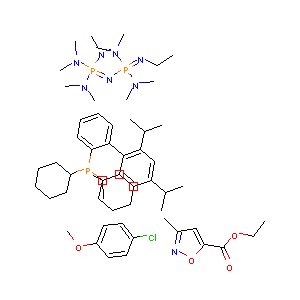

In [13]:
from rdkit.Chaem import Draw
Draw.MolToImage(mol)
#Chem.FindMolChiralCenters(mol,force=True)

In [11]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
m.GetNumAtoms()
AllChem.Compute2DCoords(m)
for atom in m.GetAtoms():
    print(atom.GetSymbol(),atom.GetIdx())



C 0
C 1
C 2
C 3
C 4
C 5
C 6
C 7
Br 8


In [14]:
import re
import glob


def get_atom_mapping_doyle(mol_dir):
    
    smiles_mapping=defaultdict(dict) 
    
    for mol_fn in glob.glob(mol_dir):
        atoms , labels, atom_mapping =[], [], []
        if 'methyl-isoxazole-5-carboxylate' in mol_fn:
            print(mol_fn)
            m = Chem.MolFromMolFile(mol_fn)
            smiles=Chem.MolToSmiles(m)
            mol_lines=open(mol_fn,'r').readlines()

            for i,line in enumerate(mol_lines[4:]):
                l=re.sub(' +', ' ', line.strip('\n'))
                l2=l.split(' ')
                if len(l2)==17:
                    atom=l2[4]
                    if atom !='' and '*' not in atom and 'H' not in atom:
                        atoms.append(atom)
                if "atom_labels" in line:
                    labels=[i.strip('*') for i in mol_lines[i+1+4].strip('\n').split(' ') if ((i!='') and ('H' not in i))]
                    print(labels)
            if len(atoms)==len(labels):
                for i in range(len(atoms)):
                    atom_mapping.append((atoms[i],labels[i]))            
                print(atom_mapping)
            else:
                print('Atoms and lables don\'t match')
                atom_mapping=[]

            if smiles not in smiles_mapping:
                print(mol_fn.split('/')[-1].split('.')[0])
                smiles_mapping[mol_fn.split('/')[-1].split('.')[0]]=atom_mapping
            else:
                print("key exsists")
    return smiles_mapping



In [ ]:
ope

In [22]:
for mol_fn in glob.glob("data/doyle_reaction_mols/*.mol"):
    if 'methyl-isoxazole-5-carboxylate' in mol_fn:
        print("te")

te


In [15]:
smiles_mapping=get_atom_mapping_doyle("data/doyle_reaction_mols/*.mol")

data/doyle_reaction_mols/methyl-isoxazole-5-carboxylate.mol
['O1', 'N1', 'C3', 'C4', 'C5', 'C1', 'O1', 'O2', 'C2']
[('O', 'O1'), ('N', 'N1'), ('C', 'C3'), ('C', 'C4'), ('C', 'C5'), ('C', 'C1'), ('O', 'O1'), ('O', 'O2'), ('C', 'C2')]
methyl-isoxazole-5-carboxylate


In [16]:
smiles_mapping['methyl-isoxazole-5-carboxylate']

[('O', 'O1'),
 ('N', 'N1'),
 ('C', 'C3'),
 ('C', 'C4'),
 ('C', 'C5'),
 ('C', 'C1'),
 ('O', 'O1'),
 ('O', 'O2'),
 ('C', 'C2')]

In [13]:
smiles_mapping['methyl-isoxazole-5-carboxylate']

{}

In [30]:
smiles_mapping['1-bromo-4-ethylbenzene']

[('C', 'C1'),
 ('C', 'C4'),
 ('C', 'C2'),
 ('C', 'C2'),
 ('C', 'C3'),
 ('C', 'C3'),
 ('C', 'C4'),
 ('C', 'C1'),
 ('Br', 'Br1')]

In [148]:
atoms=[{"name": "C1", "atomic_num": 6, "partial_charge": -0.025, "nmr_shift": 132.85}, {"name": "C2", "atomic_num": 6, "partial_charge": -0.058, "nmr_shift": 125.36}, {"name": "C3", "atomic_num": 6, "partial_charge": -0.211, "nmr_shift": 122.91}, {"name": "C4", "atomic_num": 6, "partial_charge": 0.167, "nmr_shift": 136.02}, {"name": "H2", "atomic_num": 1, "partial_charge": 0.104, "nmr_shift": 7.11}, {"name": "H3", "atomic_num": 1, "partial_charge": 0.14, "nmr_shift": 6.97}]

In [161]:
p_charge_dict=defaultdict(float)
nmr_dict=defaultdict(float)
for atom in atoms:
    p_charge_dict[atom['name']]=atom['partial_charge']
    nmr_dict[atom['name']]=atom['nmr_shift']

In [162]:
p_charge_dict

defaultdict(float,
            {'C1': -0.025,
             'C2': -0.058,
             'C3': -0.211,
             'C4': 0.167,
             'H2': 0.104,
             'H3': 0.14})

In [166]:
m=Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
partial_charges=[]
nmr_shifts=[]

for atom in m.GetAtoms():
    atom_label=smiles_mapping['1-bromo-4-ethylbenzene'][atom.GetIdx()][1]
    partial_charges.append(p_charge_dict[atom_label])
    nmr_shifts.append(nmr_dict[atom_label])
    


In [165]:
partial_charges

[-0.025, 0.167, -0.058, -0.058, -0.211, -0.211, 0.167, -0.025, 0.0]

In [167]:
nmr_shifts

[132.85, 136.02, 125.36, 125.36, 122.91, 122.91, 136.02, 132.85, 0.0]

In [92]:
mm=Chem.MolFromSmiles('CCc1ccc(Br)cc1')

In [123]:
mm.GetAtoms()

In [126]:
for atom in mm.GetAtoms():
    print(atom.GetIdx(),atom.GetSymbol())

0 C
1 C
2 C
3 C
4 C
5 C
6 Br
7 C
8 C


In [ ]:
m = Chem.MolFromMolFile('data/doyle_reaction_mols/1-bromo-4-ethylbenzene.mol')
m.GetNumAtoms()
Chem.MolToSmiles(m)
#AllChem.Compute2DCoords(m2)
#for atom in m.GetAtoms():
    #print(atom.GetSymbol(),atom.GetIdx())
#print(Chem.MolToMolBlock(m))

In [177]:
import math
from sklearn.preprocessing import LabelEncoder
file_name = args.train_dataset
path = args.dataset_path
rxns = []
degree_codec = LabelEncoder()
symbol_codec = LabelEncoder()
expl_val_codec = LabelEncoder()
bond_type_codec = LabelEncoder()
max_nbonds = 10   
symbols = set()
degrees = set()
explicit_valences = set()
bond_types = set()

a=True
charges,shifts=[math.inf,-math.inf],[math.inf,-math.inf]
with open(os.path.join(path, file_name)) as datafile:
    data = json.load(datafile)
    for line in data:

        product=line['product']
        reactants=line['reactants']
        r_yield=line['yield']
     
        rxn = Rxn(product,reactants,r_yield)
        mol = Chem.MolFromSmiles(rxn.reactants_smile)
        #atom_idx = torch.tensor([atom.GetIdx()-1 for atom in mol.GetAtoms()], dtype=torch.int64)

        mol_reactants=rxn.reactants
        for mol_idx in range(1,len(mol_reactants)):
            current_molecule=mol_reactants[mol_idx]
            atoms=current_molecule.atoms
            #p_charge_dict=defaultdict(float)
            #nmr_dict=defaultdict(float)
            for atom in atoms:
                if 'partial_charge' in atom:
                    charges[0],charges[1]= min(charges[0],atom['partial_charge']), max(charges[1],atom['partial_charge'])
                if 'nmr_shift' in atom:
                    shifts[0],shifts[1]= min(shifts[0],atom['nmr_shift']), max(shifts[1],atom['nmr_shift'])

In [178]:
charges

[-0.96, 1.858]

In [179]:
shifts

[6.41, 168.89]